In [1]:
import os
import pickle
import numpy as np

def load_cifar10_batch(filename):
    with open(filename, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
        images = batch[b'data'].reshape(-1, 3, 32, 32)  
        labels = np.array(batch[b'labels'])
        return images, labels

def load_cifar10_dataset(data_dir):
    train_images = []
    train_labels = []
    for i in range(1, 6):
        batch_file = os.path.join(data_dir, f'data_batch_{i}')
        imgs, lbls = load_cifar10_batch(batch_file)
        train_images.append(imgs)
        train_labels.append(lbls)
    train_images = np.concatenate(train_images, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)

    # 加载测试集
    test_file = os.path.join(data_dir, 'test_batch')
    test_images, test_labels = load_cifar10_batch(test_file)

    return train_images, train_labels, test_images, test_labels

# 调用加载函数
data_dir = '../cifar10/cifar-10-batches-py'
train_images, train_labels, test_images, test_labels = load_cifar10_dataset(data_dir)

In [2]:
print(train_images.shape, train_labels.shape)

(50000, 3, 32, 32) (50000,)


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class CIFAR10Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]
        img = np.transpose(img, (1, 2, 0))  
        img = Image.fromarray(img)        
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long)

In [4]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
# 创建 Dataset
train_dataset = CIFAR10Dataset(train_images[:45000], train_labels[:45000], transform=train_transform)
dev_dataset=CIFAR10Dataset(train_images[45000:], train_labels[45000:], transform=test_transform)
test_dataset = CIFAR10Dataset(test_images, test_labels, transform=test_transform)

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
dev_loader = DataLoader(dev_dataset, batch_size=128, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=0)


In [6]:
# 获取一个 batch
images, labels = next(iter(train_loader))

# 查看最小值和最大值
print("Min value:", images.min().item())
print("Max value:", images.max().item())

Min value: -1.0
Max value: 1.0


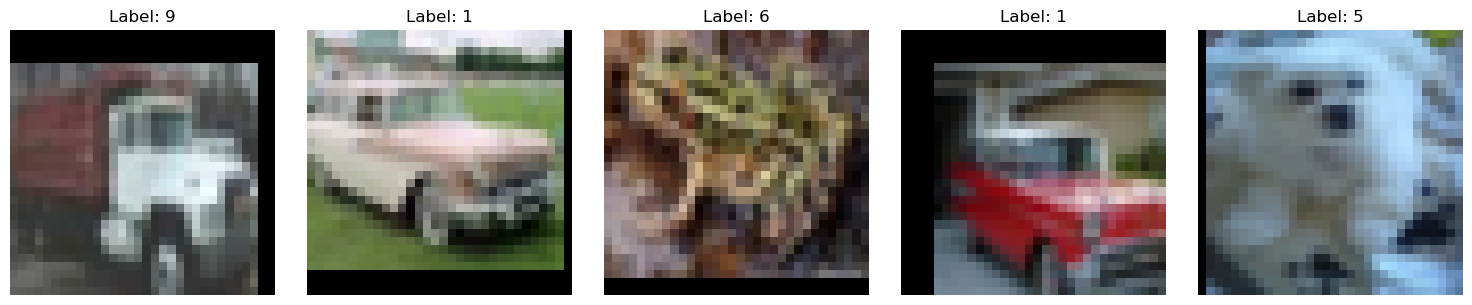

In [7]:
import matplotlib.pyplot as plt
import torchvision

# 如果你使用了 Normalize，需要定义逆变换
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
inv_normalize = torchvision.transforms.Normalize(
    mean=[-m/s for m, s in zip(mean, std)],
    std=[1/s for s in std]
)

# 获取一个 batch
images, labels = next(iter(train_loader))

# 只看前5张
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img = inv_normalize(images[i]).clamp(0, 1)  # 逆归一化并裁剪
    img = img.permute(1, 2, 0).cpu().numpy()    # CHW -> HWC
    axs[i].imshow(img)
    axs[i].set_title(f"Label: {labels[i].item()}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()


In [8]:
print(len(train_dataset), len(dev_dataset))

45000 5000


In [9]:
import torch.nn as nn
import torch
import torch.nn.functional as F

class Residual(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [10]:
class ResNetSmall(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # 输出: [B,64,32,32]
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # Stage 1
            Residual(64, 64),
            Residual(64, 64),

            # Stage 2
            Residual(64, 128, use_1x1conv=True, strides=2),  
            Residual(128, 128),

            # Stage 3
            Residual(128, 256, use_1x1conv=True, strides=2), 
            Residual(256, 256),

            nn.AdaptiveAvgPool2d((1, 1)),  
            nn.Flatten(),                 
            nn.Linear(256, num_classes)   
        )

    def forward(self, x):
        return self.net(x)

In [11]:
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetSmall().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=0.001)

In [12]:
print(device)

cuda


In [13]:
from tqdm import tqdm
train_losses, dev_losses = [], []
train_accuracies, dev_accuracies = [], []
best_acc = 0.0
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # 验证阶段
    model.eval()
    dev_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in dev_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            dev_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    dev_loss /= total
    dev_acc = correct / total
    dev_losses.append(dev_loss)
    dev_accuracies.append(dev_acc)

    print(f"Epoch {epoch+1} => Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {dev_loss:.4f}, Acc: {dev_acc:.4f}")

    if dev_acc > best_acc:
        best_acc = dev_acc
        torch.save(model.state_dict(), 'best_model.pth')

Epoch 1/100: 100%|██████████| 352/352 [01:16<00:00,  4.62it/s]


Epoch 1 => Train Loss: 1.4828, Acc: 0.4481 | Val Loss: 1.5171, Acc: 0.4954


Epoch 2/100: 100%|██████████| 352/352 [01:27<00:00,  4.02it/s]


Epoch 2 => Train Loss: 1.0651, Acc: 0.6156 | Val Loss: 0.9742, Acc: 0.6496


Epoch 3/100: 100%|██████████| 352/352 [01:25<00:00,  4.12it/s]


Epoch 3 => Train Loss: 0.8952, Acc: 0.6834 | Val Loss: 0.8675, Acc: 0.6936


Epoch 4/100: 100%|██████████| 352/352 [01:26<00:00,  4.05it/s]


Epoch 4 => Train Loss: 0.7700, Acc: 0.7332 | Val Loss: 0.9593, Acc: 0.6814


Epoch 5/100: 100%|██████████| 352/352 [01:12<00:00,  4.84it/s]


Epoch 5 => Train Loss: 0.6861, Acc: 0.7640 | Val Loss: 0.9349, Acc: 0.6968


Epoch 6/100: 100%|██████████| 352/352 [01:27<00:00,  4.03it/s]


Epoch 6 => Train Loss: 0.6243, Acc: 0.7864 | Val Loss: 1.3873, Acc: 0.6232


Epoch 7/100: 100%|██████████| 352/352 [01:25<00:00,  4.12it/s]


Epoch 7 => Train Loss: 0.5772, Acc: 0.8030 | Val Loss: 0.6841, Acc: 0.7624


Epoch 8/100: 100%|██████████| 352/352 [00:56<00:00,  6.26it/s]


Epoch 8 => Train Loss: 0.5427, Acc: 0.8156 | Val Loss: 0.7259, Acc: 0.7658


Epoch 9/100: 100%|██████████| 352/352 [00:50<00:00,  6.98it/s]


Epoch 9 => Train Loss: 0.5217, Acc: 0.8224 | Val Loss: 0.7189, Acc: 0.7664


Epoch 10/100: 100%|██████████| 352/352 [00:50<00:00,  7.03it/s]


Epoch 10 => Train Loss: 0.4930, Acc: 0.8334 | Val Loss: 0.6803, Acc: 0.7822


Epoch 11/100: 100%|██████████| 352/352 [00:50<00:00,  7.00it/s]


Epoch 11 => Train Loss: 0.4700, Acc: 0.8412 | Val Loss: 0.5662, Acc: 0.8114


Epoch 12/100: 100%|██████████| 352/352 [00:50<00:00,  7.00it/s]


Epoch 12 => Train Loss: 0.4563, Acc: 0.8431 | Val Loss: 0.5316, Acc: 0.8182


Epoch 13/100: 100%|██████████| 352/352 [00:50<00:00,  7.01it/s]


Epoch 13 => Train Loss: 0.4410, Acc: 0.8510 | Val Loss: 0.6837, Acc: 0.7830


Epoch 14/100: 100%|██████████| 352/352 [00:50<00:00,  7.02it/s]


Epoch 14 => Train Loss: 0.4319, Acc: 0.8533 | Val Loss: 0.5590, Acc: 0.8046


Epoch 15/100: 100%|██████████| 352/352 [00:50<00:00,  7.02it/s]


Epoch 15 => Train Loss: 0.4087, Acc: 0.8590 | Val Loss: 0.5586, Acc: 0.8120


Epoch 16/100: 100%|██████████| 352/352 [00:50<00:00,  7.00it/s]


Epoch 16 => Train Loss: 0.4050, Acc: 0.8636 | Val Loss: 0.5151, Acc: 0.8346


Epoch 17/100: 100%|██████████| 352/352 [00:50<00:00,  7.00it/s]


Epoch 17 => Train Loss: 0.4027, Acc: 0.8630 | Val Loss: 0.4712, Acc: 0.8342


Epoch 18/100: 100%|██████████| 352/352 [00:50<00:00,  7.01it/s]


Epoch 18 => Train Loss: 0.3844, Acc: 0.8699 | Val Loss: 0.4959, Acc: 0.8310


Epoch 19/100: 100%|██████████| 352/352 [00:50<00:00,  7.01it/s]


Epoch 19 => Train Loss: 0.3817, Acc: 0.8711 | Val Loss: 0.6193, Acc: 0.8060


Epoch 20/100: 100%|██████████| 352/352 [00:50<00:00,  7.01it/s]


Epoch 20 => Train Loss: 0.3769, Acc: 0.8730 | Val Loss: 0.5690, Acc: 0.8134


Epoch 21/100: 100%|██████████| 352/352 [00:50<00:00,  7.02it/s]


Epoch 21 => Train Loss: 0.3702, Acc: 0.8736 | Val Loss: 0.4176, Acc: 0.8636


Epoch 22/100: 100%|██████████| 352/352 [00:50<00:00,  7.02it/s]


Epoch 22 => Train Loss: 0.3662, Acc: 0.8746 | Val Loss: 0.4478, Acc: 0.8492


Epoch 23/100: 100%|██████████| 352/352 [00:50<00:00,  7.02it/s]


Epoch 23 => Train Loss: 0.3569, Acc: 0.8793 | Val Loss: 0.5697, Acc: 0.8134


Epoch 24/100: 100%|██████████| 352/352 [00:50<00:00,  7.04it/s]


Epoch 24 => Train Loss: 0.3573, Acc: 0.8790 | Val Loss: 0.5364, Acc: 0.8332


Epoch 25/100: 100%|██████████| 352/352 [00:50<00:00,  7.00it/s]


Epoch 25 => Train Loss: 0.3499, Acc: 0.8815 | Val Loss: 0.5050, Acc: 0.8334


Epoch 26/100: 100%|██████████| 352/352 [00:50<00:00,  7.00it/s]


Epoch 26 => Train Loss: 0.3427, Acc: 0.8840 | Val Loss: 0.4812, Acc: 0.8446


Epoch 27/100: 100%|██████████| 352/352 [00:50<00:00,  7.02it/s]


Epoch 27 => Train Loss: 0.3472, Acc: 0.8829 | Val Loss: 0.4313, Acc: 0.8572


Epoch 28/100: 100%|██████████| 352/352 [00:49<00:00,  7.04it/s]


Epoch 28 => Train Loss: 0.3393, Acc: 0.8843 | Val Loss: 0.4572, Acc: 0.8478


Epoch 29/100: 100%|██████████| 352/352 [00:50<00:00,  7.04it/s]


Epoch 29 => Train Loss: 0.3470, Acc: 0.8814 | Val Loss: 0.3818, Acc: 0.8696


Epoch 30/100: 100%|██████████| 352/352 [00:50<00:00,  7.00it/s]


Epoch 30 => Train Loss: 0.3302, Acc: 0.8870 | Val Loss: 0.4745, Acc: 0.8350


Epoch 31/100: 100%|██████████| 352/352 [00:50<00:00,  7.01it/s]


Epoch 31 => Train Loss: 0.3332, Acc: 0.8869 | Val Loss: 0.5269, Acc: 0.8296


Epoch 32/100: 100%|██████████| 352/352 [00:50<00:00,  7.01it/s]


Epoch 32 => Train Loss: 0.3314, Acc: 0.8878 | Val Loss: 0.5588, Acc: 0.8222


Epoch 33/100: 100%|██████████| 352/352 [00:50<00:00,  7.01it/s]


Epoch 33 => Train Loss: 0.3242, Acc: 0.8893 | Val Loss: 0.4392, Acc: 0.8552


Epoch 34/100: 100%|██████████| 352/352 [00:50<00:00,  7.02it/s]


Epoch 34 => Train Loss: 0.3243, Acc: 0.8905 | Val Loss: 0.4767, Acc: 0.8448


Epoch 35/100: 100%|██████████| 352/352 [00:50<00:00,  7.02it/s]


Epoch 35 => Train Loss: 0.3218, Acc: 0.8902 | Val Loss: 0.4190, Acc: 0.8630


Epoch 36/100: 100%|██████████| 352/352 [00:50<00:00,  7.00it/s]


Epoch 36 => Train Loss: 0.3221, Acc: 0.8914 | Val Loss: 0.5567, Acc: 0.8222


Epoch 37/100: 100%|██████████| 352/352 [00:50<00:00,  7.03it/s]


Epoch 37 => Train Loss: 0.3150, Acc: 0.8924 | Val Loss: 0.4658, Acc: 0.8478


Epoch 38/100: 100%|██████████| 352/352 [01:12<00:00,  4.86it/s]


Epoch 38 => Train Loss: 0.3108, Acc: 0.8939 | Val Loss: 0.4278, Acc: 0.8632


Epoch 39/100: 100%|██████████| 352/352 [01:06<00:00,  5.29it/s]


Epoch 39 => Train Loss: 0.3114, Acc: 0.8938 | Val Loss: 0.6982, Acc: 0.8004


Epoch 40/100: 100%|██████████| 352/352 [01:07<00:00,  5.21it/s]


Epoch 40 => Train Loss: 0.3101, Acc: 0.8951 | Val Loss: 0.4852, Acc: 0.8390


Epoch 41/100: 100%|██████████| 352/352 [00:50<00:00,  7.02it/s]


Epoch 41 => Train Loss: 0.3075, Acc: 0.8951 | Val Loss: 0.6009, Acc: 0.8166


Epoch 42/100: 100%|██████████| 352/352 [00:50<00:00,  7.01it/s]


Epoch 42 => Train Loss: 0.3088, Acc: 0.8946 | Val Loss: 0.4339, Acc: 0.8564


Epoch 43/100: 100%|██████████| 352/352 [00:50<00:00,  7.03it/s]


Epoch 43 => Train Loss: 0.3067, Acc: 0.8956 | Val Loss: 0.4768, Acc: 0.8472


Epoch 44/100: 100%|██████████| 352/352 [00:50<00:00,  7.04it/s]


Epoch 44 => Train Loss: 0.3007, Acc: 0.8974 | Val Loss: 0.5099, Acc: 0.8332


Epoch 45/100: 100%|██████████| 352/352 [00:50<00:00,  7.02it/s]


Epoch 45 => Train Loss: 0.3028, Acc: 0.8972 | Val Loss: 0.4450, Acc: 0.8574


Epoch 46/100: 100%|██████████| 352/352 [00:49<00:00,  7.05it/s]


Epoch 46 => Train Loss: 0.3016, Acc: 0.8976 | Val Loss: 0.4583, Acc: 0.8558


Epoch 47/100: 100%|██████████| 352/352 [00:50<00:00,  7.03it/s]


Epoch 47 => Train Loss: 0.2966, Acc: 0.8996 | Val Loss: 0.5363, Acc: 0.8300


Epoch 48/100: 100%|██████████| 352/352 [00:50<00:00,  7.03it/s]


Epoch 48 => Train Loss: 0.3009, Acc: 0.8982 | Val Loss: 0.3528, Acc: 0.8784


Epoch 49/100: 100%|██████████| 352/352 [00:49<00:00,  7.04it/s]


Epoch 49 => Train Loss: 0.2996, Acc: 0.8992 | Val Loss: 0.4318, Acc: 0.8598


Epoch 50/100: 100%|██████████| 352/352 [00:49<00:00,  7.05it/s]


Epoch 50 => Train Loss: 0.2909, Acc: 0.9008 | Val Loss: 0.4100, Acc: 0.8590


Epoch 51/100: 100%|██████████| 352/352 [00:49<00:00,  7.04it/s]


Epoch 51 => Train Loss: 0.2933, Acc: 0.8992 | Val Loss: 0.4454, Acc: 0.8550


Epoch 52/100: 100%|██████████| 352/352 [00:50<00:00,  7.03it/s]


Epoch 52 => Train Loss: 0.2928, Acc: 0.9003 | Val Loss: 0.3856, Acc: 0.8742


Epoch 53/100: 100%|██████████| 352/352 [00:50<00:00,  7.04it/s]


Epoch 53 => Train Loss: 0.2899, Acc: 0.9020 | Val Loss: 0.5056, Acc: 0.8426


Epoch 54/100: 100%|██████████| 352/352 [00:50<00:00,  7.04it/s]


Epoch 54 => Train Loss: 0.2895, Acc: 0.9015 | Val Loss: 0.4032, Acc: 0.8678


Epoch 55/100: 100%|██████████| 352/352 [00:49<00:00,  7.04it/s]


Epoch 55 => Train Loss: 0.2860, Acc: 0.9024 | Val Loss: 0.4458, Acc: 0.8584


Epoch 56/100: 100%|██████████| 352/352 [00:50<00:00,  7.04it/s]


Epoch 56 => Train Loss: 0.2886, Acc: 0.9009 | Val Loss: 0.4385, Acc: 0.8576


Epoch 57/100: 100%|██████████| 352/352 [00:50<00:00,  7.02it/s]


Epoch 57 => Train Loss: 0.2886, Acc: 0.9014 | Val Loss: 0.3799, Acc: 0.8768


Epoch 58/100: 100%|██████████| 352/352 [00:49<00:00,  7.06it/s]


Epoch 58 => Train Loss: 0.2873, Acc: 0.9019 | Val Loss: 0.4725, Acc: 0.8500


Epoch 59/100: 100%|██████████| 352/352 [00:49<00:00,  7.05it/s]


Epoch 59 => Train Loss: 0.2832, Acc: 0.9033 | Val Loss: 0.4323, Acc: 0.8666


Epoch 60/100: 100%|██████████| 352/352 [00:49<00:00,  7.04it/s]


Epoch 60 => Train Loss: 0.2826, Acc: 0.9045 | Val Loss: 0.4772, Acc: 0.8450


Epoch 61/100: 100%|██████████| 352/352 [00:50<00:00,  7.04it/s]


Epoch 61 => Train Loss: 0.2816, Acc: 0.9049 | Val Loss: 0.4314, Acc: 0.8634


Epoch 62/100: 100%|██████████| 352/352 [00:50<00:00,  7.04it/s]


Epoch 62 => Train Loss: 0.2851, Acc: 0.9031 | Val Loss: 0.4114, Acc: 0.8760


Epoch 63/100: 100%|██████████| 352/352 [00:49<00:00,  7.05it/s]


Epoch 63 => Train Loss: 0.2835, Acc: 0.9027 | Val Loss: 0.4448, Acc: 0.8560


Epoch 64/100: 100%|██████████| 352/352 [00:50<00:00,  7.04it/s]


Epoch 64 => Train Loss: 0.2808, Acc: 0.9048 | Val Loss: 0.4811, Acc: 0.8450


Epoch 65/100: 100%|██████████| 352/352 [00:49<00:00,  7.05it/s]


Epoch 65 => Train Loss: 0.2780, Acc: 0.9051 | Val Loss: 0.4374, Acc: 0.8478


Epoch 66/100: 100%|██████████| 352/352 [00:50<00:00,  7.03it/s]


Epoch 66 => Train Loss: 0.2780, Acc: 0.9053 | Val Loss: 0.3797, Acc: 0.8704


Epoch 67/100: 100%|██████████| 352/352 [00:50<00:00,  7.03it/s]


Epoch 67 => Train Loss: 0.2802, Acc: 0.9054 | Val Loss: 0.4117, Acc: 0.8642


Epoch 68/100: 100%|██████████| 352/352 [00:50<00:00,  7.00it/s]


Epoch 68 => Train Loss: 0.2796, Acc: 0.9056 | Val Loss: 0.5531, Acc: 0.8230


Epoch 69/100: 100%|██████████| 352/352 [00:51<00:00,  6.83it/s]


Epoch 69 => Train Loss: 0.2808, Acc: 0.9042 | Val Loss: 0.4297, Acc: 0.8636


Epoch 70/100: 100%|██████████| 352/352 [00:50<00:00,  6.90it/s]


Epoch 70 => Train Loss: 0.2781, Acc: 0.9062 | Val Loss: 0.4291, Acc: 0.8636


Epoch 71/100: 100%|██████████| 352/352 [00:50<00:00,  6.93it/s]


Epoch 71 => Train Loss: 0.2713, Acc: 0.9082 | Val Loss: 0.3744, Acc: 0.8816


Epoch 72/100: 100%|██████████| 352/352 [01:11<00:00,  4.90it/s]


Epoch 72 => Train Loss: 0.2772, Acc: 0.9058 | Val Loss: 0.4322, Acc: 0.8612


Epoch 73/100: 100%|██████████| 352/352 [01:17<00:00,  4.57it/s]


Epoch 73 => Train Loss: 0.2785, Acc: 0.9053 | Val Loss: 0.3892, Acc: 0.8712


Epoch 74/100: 100%|██████████| 352/352 [00:57<00:00,  6.14it/s]


Epoch 74 => Train Loss: 0.2725, Acc: 0.9062 | Val Loss: 0.4727, Acc: 0.8472


Epoch 75/100: 100%|██████████| 352/352 [01:20<00:00,  4.40it/s]


Epoch 75 => Train Loss: 0.2717, Acc: 0.9078 | Val Loss: 0.3895, Acc: 0.8734


Epoch 76/100: 100%|██████████| 352/352 [01:21<00:00,  4.34it/s]


Epoch 76 => Train Loss: 0.2782, Acc: 0.9039 | Val Loss: 0.4409, Acc: 0.8580


Epoch 77/100: 100%|██████████| 352/352 [01:23<00:00,  4.20it/s]


Epoch 77 => Train Loss: 0.2700, Acc: 0.9081 | Val Loss: 0.5091, Acc: 0.8414


Epoch 78/100: 100%|██████████| 352/352 [01:21<00:00,  4.32it/s]


Epoch 78 => Train Loss: 0.2643, Acc: 0.9091 | Val Loss: 0.4106, Acc: 0.8704


Epoch 79/100: 100%|██████████| 352/352 [01:10<00:00,  5.00it/s]


Epoch 79 => Train Loss: 0.2681, Acc: 0.9095 | Val Loss: 0.4423, Acc: 0.8640


Epoch 80/100: 100%|██████████| 352/352 [01:13<00:00,  4.78it/s]


Epoch 80 => Train Loss: 0.2671, Acc: 0.9093 | Val Loss: 0.4361, Acc: 0.8640


Epoch 81/100: 100%|██████████| 352/352 [01:26<00:00,  4.08it/s]


Epoch 81 => Train Loss: 0.2694, Acc: 0.9076 | Val Loss: 0.4053, Acc: 0.8668


Epoch 82/100: 100%|██████████| 352/352 [01:21<00:00,  4.31it/s]


Epoch 82 => Train Loss: 0.2694, Acc: 0.9091 | Val Loss: 0.4445, Acc: 0.8582


Epoch 83/100: 100%|██████████| 352/352 [00:50<00:00,  7.00it/s]


Epoch 83 => Train Loss: 0.2701, Acc: 0.9074 | Val Loss: 0.3917, Acc: 0.8724


Epoch 84/100: 100%|██████████| 352/352 [00:59<00:00,  5.96it/s]


Epoch 84 => Train Loss: 0.2643, Acc: 0.9105 | Val Loss: 0.4378, Acc: 0.8602


Epoch 85/100: 100%|██████████| 352/352 [01:21<00:00,  4.33it/s]


Epoch 85 => Train Loss: 0.2675, Acc: 0.9096 | Val Loss: 0.4200, Acc: 0.8668


Epoch 86/100: 100%|██████████| 352/352 [00:51<00:00,  6.81it/s]


Epoch 86 => Train Loss: 0.2765, Acc: 0.9053 | Val Loss: 0.5211, Acc: 0.8388


Epoch 87/100: 100%|██████████| 352/352 [01:23<00:00,  4.20it/s]


Epoch 87 => Train Loss: 0.2644, Acc: 0.9106 | Val Loss: 0.3663, Acc: 0.8814


Epoch 88/100: 100%|██████████| 352/352 [00:54<00:00,  6.42it/s]


Epoch 88 => Train Loss: 0.2623, Acc: 0.9117 | Val Loss: 0.3907, Acc: 0.8676


Epoch 89/100: 100%|██████████| 352/352 [00:50<00:00,  7.01it/s]


Epoch 89 => Train Loss: 0.2610, Acc: 0.9113 | Val Loss: 0.5557, Acc: 0.8224


Epoch 90/100: 100%|██████████| 352/352 [00:50<00:00,  6.99it/s]


Epoch 90 => Train Loss: 0.2713, Acc: 0.9071 | Val Loss: 0.3762, Acc: 0.8780


Epoch 91/100: 100%|██████████| 352/352 [00:50<00:00,  7.02it/s]


Epoch 91 => Train Loss: 0.2648, Acc: 0.9098 | Val Loss: 0.3840, Acc: 0.8726


Epoch 92/100: 100%|██████████| 352/352 [00:50<00:00,  7.03it/s]


Epoch 92 => Train Loss: 0.2671, Acc: 0.9088 | Val Loss: 0.4307, Acc: 0.8632


Epoch 93/100: 100%|██████████| 352/352 [00:49<00:00,  7.04it/s]


Epoch 93 => Train Loss: 0.2701, Acc: 0.9078 | Val Loss: 0.4141, Acc: 0.8676


Epoch 94/100: 100%|██████████| 352/352 [00:50<00:00,  7.02it/s]


Epoch 94 => Train Loss: 0.2614, Acc: 0.9101 | Val Loss: 0.4398, Acc: 0.8628


Epoch 95/100: 100%|██████████| 352/352 [00:50<00:00,  7.01it/s]


Epoch 95 => Train Loss: 0.2648, Acc: 0.9089 | Val Loss: 0.5281, Acc: 0.8324


Epoch 96/100: 100%|██████████| 352/352 [00:50<00:00,  7.03it/s]


Epoch 96 => Train Loss: 0.2592, Acc: 0.9120 | Val Loss: 0.4642, Acc: 0.8504


Epoch 97/100: 100%|██████████| 352/352 [00:50<00:00,  7.02it/s]


Epoch 97 => Train Loss: 0.2683, Acc: 0.9091 | Val Loss: 0.4591, Acc: 0.8516


Epoch 98/100: 100%|██████████| 352/352 [00:50<00:00,  7.01it/s]


Epoch 98 => Train Loss: 0.2606, Acc: 0.9116 | Val Loss: 0.3931, Acc: 0.8740


Epoch 99/100: 100%|██████████| 352/352 [00:50<00:00,  7.00it/s]


Epoch 99 => Train Loss: 0.2562, Acc: 0.9128 | Val Loss: 0.4209, Acc: 0.8712


Epoch 100/100: 100%|██████████| 352/352 [00:50<00:00,  7.02it/s]


Epoch 100 => Train Loss: 0.2570, Acc: 0.9116 | Val Loss: 0.5553, Acc: 0.8366


In [14]:
import numpy as np

# 将4个列表转为 numpy 数组并堆叠为 (epochs, 4) 的二维数组
results = np.column_stack((train_losses, dev_losses, train_accuracies, dev_accuracies))

# 保存为 txt 文件，添加列名
np.savetxt("adam_weight_decay0001.txt", results, 
           header="Train_Loss Validation_Loss Train_Accuracy Validation_Accuracy", 
           fmt='%.6f', delimiter='\t')

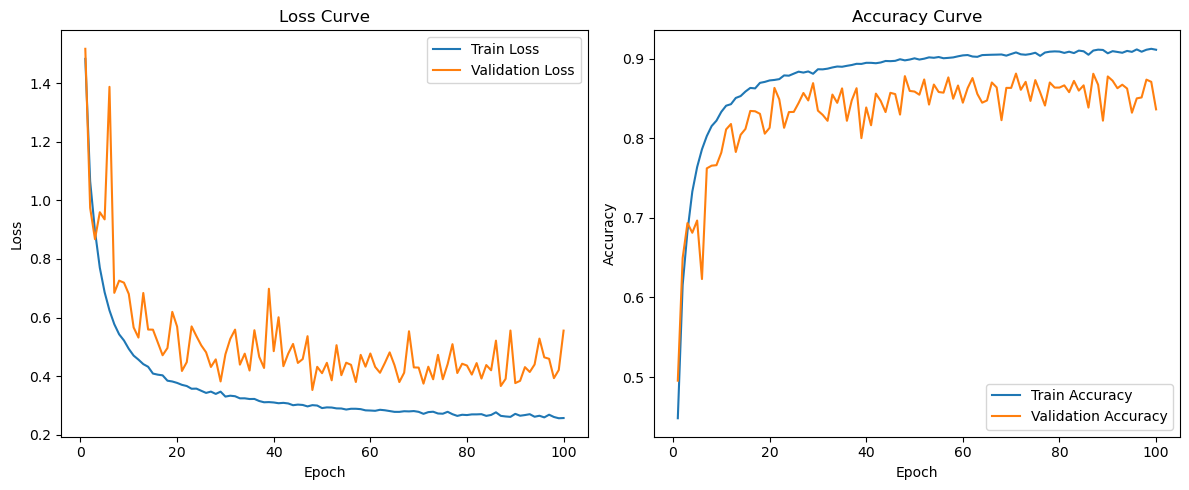

In [15]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, dev_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, dev_accuracies, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.tight_layout()
plt.savefig("training_curve.png")
plt.show()


In [21]:
model.eval()  # 设置为评估模式
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 83.26%


In [22]:
model2 = ResNetSmall(num_classes=10)
model2.load_state_dict(torch.load('best_model2.pth'))
model2.to(device)
model2.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 87.32%
